# Day2

In [113]:
import spacy
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.de.stop_words import STOP_WORDS
import pandas as pd
from sklearn.cluster import KMeans
import time

In [3]:
%run src/file_utils.py
%run src/configuration.py

In [49]:
document_test = ['BMW-AnnualReport-2016.json']

In [24]:
vocab_documents = ['BMW-AnnualReport-2016.json', 'CarlZeissMeditec-AnnualReport-2016.json', 'BVB-AnnualReport-2016.json']

In [4]:
documents = ['BMW-AnnualReport-2015.json', 'BMW-AnnualReport-2016.json', 'BMW-AnnualReport-2017.json', 
 'CarlZeissMeditec-AnnualReport-2015.json', 'CarlZeissMeditec-AnnualReport-2016.json', 'CarlZeissMeditec-AnnualReport-2017.json',
 'BVB-AnnualReport-2015.json', 'BVB-AnnualReport-2016.json', 'BVB-AnnualReport-2017.json']

In [5]:
TYPE = 'type'
PARAGRAPH = 'paragraph'
CONTENT = 'content'

In [6]:
def readContentOfFile(file_name):
    content = ''
    try:
        with open(file_name) as f:
            data = json.load(f)
            for item in data:
                typeDoc = item[TYPE]
                if typeDoc == PARAGRAPH:
                    content += item[CONTENT]
    except:
        FileUtils.fix_json(file_name)
        with open(file_name) as f:
            data = json.load(f)
            for item in data:
                typeDoc = item[TYPE]
                if typeDoc == PARAGRAPH:
                    content += item[CONTENT]
    return content

# Clustering without lemmatization

In [40]:
common_vocabularly = set()
for document in documents:
    content_of_document = readContentOfFile(FILE_PATH + document)
    nlp = spacy.load("de")
    sentence = nlp(content_of_document)
    filtered_words = [word for word in sentence if word.lower_ not in STOP_WORDS]
    filtered_words_withoutdigits = [word for word in filtered_words if not word.is_digit]
    filtered_words_withoutpunc = [word for word in filtered_words_withoutdigits if word.pos_ != 'PUNCT']
    vocabularly = set()
    for word in filtered_words_withoutpunc:
        vocabularly.add(word.text.replace('\n', '').strip().lower())
    new_vocab = set()
    for u in vocabularly:
        if u != '':
            new_vocab.add(u)
    vectorizer = TfidfVectorizer(vocabulary=new_vocab)
    tfidf_matrix = vectorizer.fit_transform([content_of_document])
    feature_names = vectorizer.get_feature_names()
    corpus_index = [n for n in ['Values']]
    df = pd.DataFrame(tfidf_matrix.T.todense(), index=feature_names, columns=corpus_index)
    df = df.sort_values(by=['Values'], ascending=False)
    common_vocabularly.update(df.head(1000).index.values.tolist())


In [42]:
vectorizer = TfidfVectorizer(vocabulary=common_vocabularly)

In [46]:
tfidf_matrix = vectorizer.fit_transform(
    [readContentOfFile(FILE_PATH + 'BVB-AnnualReport-2011.json'), 
     readContentOfFile(FILE_PATH + 'BVB-AnnualReport-2012.json'), 
     readContentOfFile(FILE_PATH + 'BMW-AnnualReport-2012.json'),
     readContentOfFile(FILE_PATH + 'BMW-AnnualReport-2011.json'),
     readContentOfFile(FILE_PATH + 'CarlZeissMeditec-AnnualReport-2013.json'),
     readContentOfFile(FILE_PATH + 'CarlZeissMeditec-AnnualReport-2012.json'),
     readContentOfFile(FILE_PATH + 'BVB-AnnualReport-2013.json'), 
     readContentOfFile(FILE_PATH + 'BMW-AnnualReport-2013.json'),])

In [47]:
km = KMeans(n_clusters=3, init='k-means++')
km.fit(tfidf_matrix)
km.labels_

array([1, 1, 2, 2, 0, 0, 1, 2], dtype=int32)

# Clustering with lemmatization

In [306]:
nlp = spacy.load("de")
def perform_lemmatization(document):
    content_of_document = readContentOfFile(document)
    sentence = nlp(content_of_document)
    filtered_words = [word for word in sentence if word.lower_ not in STOP_WORDS]
    filtered_words_withoutdigits = [word for word in filtered_words if not word.is_digit]
    filtered_words_withoutpunc = [word for word in filtered_words_withoutdigits if word.pos_ != 'PUNCT']
    filtered_lemmas = [word.lemma_ for word in filtered_words_withoutpunc]
    lemmatized_content = " ".join(item for item in filtered_lemmas)
    return lemmatized_content.lower()

In [273]:
start_time = time.time()
common_vocabularly_lem = set()
for document in documents:
    content_of_document = readContentOfFile(FILE_PATH + document)
    sentence = nlp(content_of_document)
    filtered_words = [word for word in sentence if word.lower_ not in STOP_WORDS]
    filtered_words_withoutdigits = [word for word in filtered_words if not word.is_digit]
    filtered_words_withoutcurrency = [word for word in filtered_words_withoutdigits if not word.is_currency]
    filtered_words_withoutverbs = [word for word in filtered_words_withoutcurrency if word.pos_ != 'VERB']
    filtered_words_withoutnum = [word for word in filtered_words_withoutverbs if word.pos_ != 'NUM']
    filtered_words_withoutsym = [word for word in filtered_words_withoutnum if word.pos_ != 'SYM']
    filtered_words_withoutpunc = [word for word in filtered_words_withoutsym if word.pos_ != 'PUNCT']
    filtered_lemmas = [word.lemma_ for word in filtered_words_withoutpunc]
    vocabularly = set()
    for word in filtered_lemmas:
        vocabularly.add(word.replace('\n', '').strip().lower())
    new_vocab = set()
    for u in vocabularly:
        if u != '':
            new_vocab.add(u)

#     lemmatized_content = " ".join(item for item in filtered_lemmas)
#     vectorizer = TfidfVectorizer(vocabulary=new_vocab)
#     tfidf_matrix = vectorizer.fit_transform([lemmatized_content])
#     feature_names = vectorizer.get_feature_names()
#     corpus_index = [n for n in ['Values']]
#     df = pd.DataFrame(tfidf_matrix.T.todense(), index=feature_names, columns=corpus_index)
#     df = df.sort_values(by=['Values'], ascending=False)
#     print (df.head(5).index.values.tolist())
#     common_vocabularly_lem.update(df.head(1000).index.values.tolist())
    common_vocabularly_lem.update(new_vocab)
common_vocabularly_lem.remove('million')
common_vocabularly_lem.remove('tausend')
common_vocabularly_lem.remove('eur')
common_vocabularly_lem.remove('teur')
print (time.time() - start_time)

55.265536069869995


In [259]:
'teur' in common_vocabularly_lem

False

In [93]:
#common_vocabularly_lem.remove("borussia")
#common_vocabularly_lem.remove("dortmund")
#common_vocabularly_lem.remove("bmw")
#common_vocabularly_lem.remove("group")
#common_vocabularly_lem.remove("zeiss")
#common_vocabularly_lem.remove("carl")

In [ ]:
vectorizer = TfidfVectorizer(vocabulary=common_vocabularly_lem)

In [95]:
tfidf_matrix = vectorizer.fit_transform(
    [perform_lemmatization(FILE_PATH + 'BVB-AnnualReport-2011.json'), 
     perform_lemmatization(FILE_PATH + 'BVB-AnnualReport-2012.json'), 
     perform_lemmatization(FILE_PATH + 'BMW-AnnualReport-2012.json'),
     perform_lemmatization(FILE_PATH + 'BMW-AnnualReport-2011.json'),
     perform_lemmatization(FILE_PATH + 'CarlZeissMeditec-AnnualReport-2013.json'),
     perform_lemmatization(FILE_PATH + 'CarlZeissMeditec-AnnualReport-2012.json'),
     perform_lemmatization(FILE_PATH + 'BVB-AnnualReport-2013.json'), 
     perform_lemmatization(FILE_PATH + 'BMW-AnnualReport-2013.json'),])

In [307]:
start_time = time.time()
lemm_docs_prep = [
     perform_lemmatization(FILE_PATH + 'BVB-AnnualReport-2015.json'), 
     perform_lemmatization(FILE_PATH + 'BVB-AnnualReport-2016.json'), 
     perform_lemmatization(FILE_PATH + 'BVB-AnnualReport-2017.json'),
     perform_lemmatization(FILE_PATH + 'BMW-AnnualReport-2015.json'),
     perform_lemmatization(FILE_PATH + 'BMW-AnnualReport-2016.json'),
     perform_lemmatization(FILE_PATH + 'BMW-AnnualReport-2017.json'),
     perform_lemmatization(FILE_PATH + 'CarlZeissMeditec-AnnualReport-2015.json'),
     perform_lemmatization(FILE_PATH + 'CarlZeissMeditec-AnnualReport-2016.json'),
     perform_lemmatization(FILE_PATH + 'CarlZeissMeditec-AnnualReport-2017.json')]
print (time.time() - start_time)

56.214717388153076


In [308]:
vectorizer = TfidfVectorizer(vocabulary=common_vocabularly_lem)
start_time = time.time()
tfidf_matrix = vectorizer.fit_transform(lemm_docs_prep)
print (time.time() - start_time)

0.2659912109375


In [309]:
feature_names = vectorizer.get_feature_names()
corpus_index = [n for n in [
    'BVB-2015', 'BVB-2016', 'BVB-2017', 
    'BMW-2015', 'BMW-2016', 'BMW-2017',
    'CZM-2015', 'CZM-2016', 'CZM-2017']]
df = pd.DataFrame(tfidf_matrix.T.todense(), index=feature_names, columns=corpus_index)

In [310]:
print(len(feature_names))

18958


In [330]:
df = df.sort_values(by=['BVB-2016'], ascending=False)
df.head(10)

,BVB-2015,BVB-2016,BVB-2017,BMW-2015,BMW-2016,BMW-2017,CZM-2015,CZM-2016,CZM-2017
dortmund,0.597689,0.619811,0.608634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
borussia,0.546458,0.580249,0.557550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gmbh,0.148820,0.141459,0.140906,0.010211,0.008022,0.008022,0.015530,0.013187,0.010345
risiko,0.103372,0.112402,0.109678,0.069048,0.073268,0.073268,0.064861,0.056045,0.058375
bvb,0.075138,0.089382,0.089033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
uefa,0.092215,0.086451,0.068599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sportlich,0.098284,0.084332,0.085154,0.000000,0.000808,0.000808,0.000000,0.000000,0.000000
vorjahr,0.100699,0.084110,0.092922,0.040359,0.054015,0.054015,0.079477,0.075826,0.104188
kgaa,0.083474,0.080867,0.065592,0.000000,0.000808,0.000808,0.000000,0.000000,0.000000
league,0.080261,0.080590,0.061301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [331]:
df = df.sort_values(by=['BMW-2016'], ascending=False)
df.head(10)

,BVB-2015,BVB-2016,BVB-2017,BMW-2015,BMW-2016,BMW-2017,CZM-2015,CZM-2016,CZM-2017
bmw,0.000000,0.000000,0.000000,0.852596,0.845486,0.845486,0.000000,0.000000,0.000000
group,0.000000,0.000845,0.000842,0.269279,0.277248,0.277248,0.002020,0.003644,0.001634
fahrzeug,0.000000,0.000000,0.000000,0.095975,0.112731,0.112731,0.000000,0.000000,0.000000
unternehmen,0.050795,0.055054,0.060932,0.077314,0.083429,0.083429,0.104142,0.116211,0.104927
automobile,0.000000,0.000000,0.006448,0.063394,0.080589,0.080589,0.000000,0.000000,0.000000
segment,0.006238,0.003823,0.004570,0.067103,0.073268,0.073268,0.010049,0.008242,0.008867
risiko,0.103372,0.112402,0.109678,0.069048,0.073268,0.073268,0.064861,0.056045,0.058375
motorrad,0.000000,0.000000,0.000000,0.053113,0.064564,0.064564,0.000000,0.000000,0.000000
mitglied,0.018714,0.016822,0.018280,0.058350,0.063641,0.063641,0.024665,0.018132,0.014040
höhe,0.082876,0.069582,0.085305,0.072451,0.063106,0.063106,0.060293,0.058518,0.059114


In [332]:
df = df.sort_values(by=['CZM-2016'], ascending=False)
df.head(10)

,BVB-2015,BVB-2016,BVB-2017,BMW-2015,BMW-2016,BMW-2017,CZM-2015,CZM-2016,CZM-2017
zeiss,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.563689,0.582796,0.577723
carl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.483162,0.473818,0.488516
meditec,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.411388,0.423277,0.406389
konzern,0.042775,0.040526,0.044176,0.030634,0.029949,0.029949,0.199149,0.197806,0.236455
unternehmen,0.050795,0.055054,0.060932,0.077314,0.083429,0.083429,0.104142,0.116211,0.104927
vj,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110737,0.098091,0.000000
geschäftsjahr,0.065944,0.066524,0.073881,0.047166,0.048667,0.048667,0.098661,0.089013,0.093104
vorjahr,0.100699,0.084110,0.092922,0.040359,0.054015,0.054015,0.079477,0.075826,0.104188
gruppe,0.012476,0.016822,0.019041,0.005835,0.005348,0.005348,0.055725,0.066760,0.022168
erfolgen,0.070400,0.062701,0.070072,0.033551,0.041714,0.041714,0.059379,0.064287,0.050247


In [239]:
km = KMeans(n_clusters=3, init='k-means++')
km.fit(tfidf_matrix)
km.labels_

array([2, 2, 2, 0, 0, 0, 1, 1, 1], dtype=int32)

# Picking topic of a paragraph

In [127]:
def readContentOfParagraphs(file_name):
    contents = []
    try:
        with open(file_name) as f:
            data = json.load(f)
            for item in data:
                typeDoc = item[TYPE]
                if typeDoc == PARAGRAPH:
                    contents.append(item[CONTENT])
    except:
        FileUtils.fix_json(file_name)
        with open(file_name) as f:
            data = json.load(f)
            for item in data:
                typeDoc = item[TYPE]
                if typeDoc == PARAGRAPH:
                    contents.append(item[CONTENT])
    return contents

In [128]:
def lemmatize_paragraphs(paragraphs):
    lemmatized_paragraphs = []
    for paragraph in paragraphs:
        nlp = spacy.load("de")
        sentence = nlp(paragraph)
        filtered_words = [word for word in sentence if word.lower_ not in STOP_WORDS]
        filtered_words_withoutdigits = [word for word in filtered_words if not word.is_digit]
        filtered_words_withoutpunc = [word for word in filtered_words_withoutdigits if word.pos_ != 'PUNCT']
        filtered_lemmas = [word.lemma_ for word in filtered_words_withoutpunc]
        lemmatized_content = " ".join(item for item in filtered_lemmas)
        lemmatized_paragraphs.append(lemmatized_content)
    return lemmatized_paragraphs

In [176]:
lem_pars = lemmatize_paragraphs(readContentOfParagraphs(FILE_PATH + 'BVB-AnnualReport-2017.json'))

In [280]:
vectorizer_par = TfidfVectorizer(vocabulary=common_vocabularly_lem)

tfidf_matrix_par = vectorizer_par.fit_transform(lem_pars)

In [283]:
feature_names = vectorizer_par.get_feature_names()
corpus_index = ['P' + str(n) for n in range(len(lem_pars))]
df_par = pd.DataFrame(tfidf_matrix_par.T.todense(), index=feature_names, columns=corpus_index)

In [285]:
row = df_par.loc[['prämie']]
for i in row:
    if(row[i].prämie != 0):
        print ((str(i) + " " + str(row[i].prämie)))

P161 0.25028474875555506
P167 0.1743876932987562
P313 0.4535727830160994
P449 0.1751518886322904
P450 0.24473899536512775


In [290]:
df_copy = pd.DataFrame()
df_copy["Values"] = df_par["P313"]
df_copy = df_copy.sort_values(by=['Values'], ascending=False)
df_copy.head(7)

,Values
lizenzabteilung,0.467688
prämie,0.453573
zahlen,0.431300
sportliche,0.387974
erfolgen,0.249254
höhe,0.245653
geschäftsjahr,0.241374


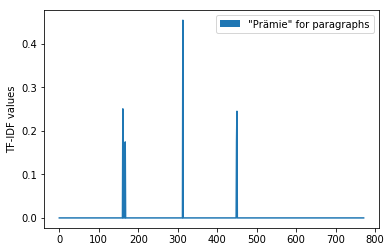

In [302]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.plot([row[i].prämie for i in row])
red_patch = mpatches.Patch(label='\"Prämie\" for paragraphs')
plt.legend(handles=[red_patch])
plt.ylabel('TF-IDF values')
plt.show()

In [284]:
df_par = df_par.sort_values(by=['P313'], ascending=False)
df_par.head(7)

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P762,P763,P764,P765,P766,P767,P768,P769,P770,P771
lizenzabteilung,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prämie,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zahlen,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sportliche,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
erfolgen,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
höhe,0.183343,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.254540,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
geschäftsjahr,0.000000,0.0,0.092926,0.145927,0.0,0.0,0.0,0.085742,0.083369,0.177828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
readContentOfParagraphs(FILE_PATH + 'BVB-AnnualReport-2017.json')[167]

'Die Erlöse aus der internationalen TV-Vermarktung\nverzeichneten im abgelaufenen Geschäftsjahr\n2016/2017 den größten Anstieg. Der Umsatz be-\ntrug im Berichtszeitraum vom 01. Juli 2016 bis\nzum 30. Juni 2017 TEUR 50.993 (Vorjahr TEUR\n17.233). Die Erlöse enthalten die Ausschüttungen\nfür die Teilnahme an den Spielen der UEFA Cham-\npions League in 2016/2017 sowie die das Vorjahr\nbetreffenden Überschussbeteiligungen.\nDie Ausschüttung der UEFA für die UEFA Champions\nLeague erfolgte analog der letzten Jahre. Sie be-\ninhaltet den Marketpool, Start- und Spielprämien\nsowie leistungsbezogene Prämien.\n'

In [197]:
nlp = spacy.load("de")
sentence = nlp(content_of_all_documents)

In [198]:
filtered_words = [word for word in sentence if word.lower_ not in STOP_WORDS]
filtered_words_withoutpunc = [word for word in filtered_words if word.pos_ != 'PUNCT']

In [199]:
vocabularly = []
for word in filtered_words_withoutpunc:
    vocabularly.append(word.text.replace('\n', '').lower())

In [200]:
new_vocab = set()
for u in vocabularly:
    if u != '':
        new_vocab.add(u)

In [202]:
vectorizer = TfidfVectorizer(vocabulary=new_vocab)

In [232]:
tfidf_matrix = vectorizer.fit_transform([readContentOfFile(FILE_PATH + 'BVB-AnnualReport-2016.json'), readContentOfFile(FILE_PATH + 'BMW-AnnualReport-2016.json')])

In [233]:
print (len(new_vocab))

14420


In [234]:
feature_names = vectorizer.get_feature_names()
corpus_index = [n for n in ['A', 'B']]
import pandas as pd
df = pd.DataFrame(tfidf_matrix.T.todense(), index=feature_names, columns=corpus_index)
#df['1'].argmax()
# print(df.)

In [235]:
print (df['A'].argmax())

dortmund


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [238]:
print (df.sort_values(by=['B'], ascending=False))

                               A         B
bmw                     0.000000  0.778350
group                   0.000871  0.314828
2016                    0.160191  0.173860
2015                    0.147132  0.169833
automobile              0.000000  0.083967
unternehmen             0.040048  0.079211
höhe                    0.079225  0.079211
risiken                 0.060072  0.078539
vorstand                0.001741  0.073169
vorstands               0.000871  0.071826
aufsichtsrat            0.053107  0.066456
segment                 0.002612  0.062429
vorjahr                 0.084449  0.061086
geschäftsjahr           0.075743  0.061086
aufsichtsrats           0.010447  0.053702
beziehungsweise         0.000000  0.051890
entwicklung             0.017412  0.051017
fahrzeuge               0.000000  0.050947
mini                    0.000000  0.050947
wesentlichen            0.047883  0.050346
compliance              0.001741  0.049674
2017                    0.023506  0.047661
rahmen     